In [1]:
import numpy as np
import pandas as pd
import datatable
import itertools as it
from owlready2 import *
import math
import joblib

import pickle
from bayes_opt import BayesianOptimization
#para depurar los que letras que no están en el codigo ascii
import unicodedata
import functools
import spacy
import stanfordnlp
#from spacy_stanfordnlp import StanfordNLPLanguage
from sklearn.decomposition import LatentDirichletAllocation
from sklearn import metrics
#from wiki_dump_reader import Cleaner, iterate
from sklearn.decomposition import TruncatedSVD

from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import pairwise_distances

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import chi2
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize,scale



#import pyLDAvis
#import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import SVG

import random
from sklearn.externals import joblib


#Operaciones con gráficos
import scattertext as st
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator

import networkx as nx

import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool, LabelSet, ColumnDataSource, Range1d
from bokeh.plotting import figure, show, output_notebook
from sklearn.manifold import TSNE

#import gensim
#import gensim.corpora as corpora
#from gensim.models import CoherenceModel
#from gensim.models import HdpModel

warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from multiprocessing import  Pool
import math
import scipy.sparse as sp


from sklearn.model_selection import *
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix



In [2]:
import json

with open('../config/config.json', 'r') as f:
    config = json.load(f)


In [3]:
interimpath = '../data/interim/20newsgroup/corpus_normalizado.csv'

In [4]:
interimpath

'../data/interim/20newsgroup/corpus_normalizado.csv'

In [5]:
corpus = pd.read_csv(interimpath)

corpus = corpus.loc[:,['cleaned_text','Target']]
corpus.Target = corpus.Target.astype(int)
corpus.head()

,cleaned_text,Target
0,organization post office carnegie mellon pitts...,0
1,summary seek recommendation vlb video card nnt...,1
2,line 95 nntp post host viktoria.dsv.su.se orga...,0
3,originator guyd pal500.austin.ibm.com organiza...,1
4,organization sophomore mechanical engineer car...,0


In [12]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


In [7]:
stop_words.append('be')
stop_words.append('don')
from sklearn.feature_extraction import text
my_stop_words = text.ENGLISH_STOP_WORDS.union(["be","don"])


In [8]:
random.seed(100)

Para hacer LDA, no vamos a utilizar todo el corpus. Seleccionaremos aleatoriamente 100.000 textos de clase positiva y sin clasificar para posteriormente hacer LDA.

In [9]:
tfidf = TfidfVectorizer(min_df=0.05,max_df=0.95, stop_words=['english','spanish'], ngram_range=(1,1))
#por ahora no pongo ngramas
joblib.dump(tfidf,'../objects/'+'20newsgroup'+'/tfidf_object')

['../objects/20newsgroup/tfidf_object']

In [10]:
dtm = tfidf.fit_transform(corpus.iloc[:,0])

In [11]:
dtm

<18846x253 sparse matrix of type '<class 'numpy.float64'>'
	with 501379 stored elements in Compressed Sparse Row format>

### Anteriormente, hemos realizado un grid search. Vamos a utilizar los parámetros que mejor funcionaron en su momento

from sklearn.model_selection import GridSearchCV
search_params = { 'topic_word_prior':[0.5,0.7,0,0.95,0.99], # hemos partido de 0.5, 0.7, 0,9, 0.95 y 0.99
                 'doc_topic_prior':[0.01,0.015,0.05,0.3,0.5]}

LDA = LatentDirichletAllocation(n_components=2,random_state=42,n_jobs=10,batch_size=50000,  evaluate_every = 100,  mean_change_tol=0.05)

model = GridSearchCV(LDA, param_grid=search_params)
from sklearn.utils import parallel_backend
i = time.time()
with parallel_backend('threading'):
    # Do the Grid Search
    model.fit(dtm)

    joblib.dump(model, 'lda_model4.pkl')

f = time.time()
elapsed = f - i
print('transcurridos {0} s'.format(elapsed))


## Ya sabemos que nuestro mejor modelo tiene unos priors determinados, 
joblib.dump(modelo,'../objects/'+config.get('corpus')+'/modelo_gridsearch.final')


In [12]:
LDA = LatentDirichletAllocation(n_components=2,random_state=42,topic_word_prior = 0.95,doc_topic_prior = 0.015,n_jobs=10,max_iter=250,mean_change_tol=0.05)
joblib.dump(LDA,'../objects/20newsgroup/lda.final')


['../objects/20newsgroup/lda.final']

In [13]:
#tfidf = joblib.load('tfidf')
tfidf

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.95, max_features=None, min_df=0.05,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=['english', 'spanish'], strip_accents=None,
        sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, use_idf=True, vocabulary=None)

In [14]:
texts = corpus.iloc[:,0]
texts = list(texts.values)

In [18]:
feature_names = tfidf.get_feature_names()

In [ ]:
feature_names

In [15]:
i = time.time()
from sklearn.utils import parallel_backend
i = time.time()
with parallel_backend('threading'):
    modelo = LDA.fit(dtm)
print (' terminado en {0} min'.format((time.time() - i) / 60))

 terminado en 19.22637332677841 min


In [19]:
joblib.dump(modelo,'../objects/20newsgroup/final_lda_fit.final.pck')
joblib.dump(feature_names,'../objects/20newsgroup/feature_names.final')


['../objects/20newsgroup/feature_names.final']

In [20]:
#modelo = joblib.load('final_lda.pck')
#modelo = joblib.load('final_lda.final.pck')


In [1]:
 from sklearn.externals import joblib
modelo = joblib.load('../objects/20newsgroup/final_lda_fit.final.pck')

In [2]:
tfidf = joblib.load('../objects/20newsgroup/tfidf_object')

In [3]:
feature_names = joblib.load('../objects/20newsgroup/feature_names.final')

In [6]:
for index,topic in enumerate(modelo.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([feature_names[i] for i in topic.argsort()[-15:]])
    joblib.dump([feature_names[i] for i in topic.argsort()],'../objects/20newsgroup/topics'+str(index))
    print('\n')
    

THE TOP 15 WORDS FOR TOPIC #0
['god', 'year', 'time', 'post', 'say', 'have', 'like', 'know', 'don', 'people', 'think', 'article', 'write', 'com', 'edu']


THE TOP 15 WORDS FOR TOPIC #1
['use', 'know', 'file', 'be', 'system', 'mail', 'distribution', 'com', 'thank', 'window', 'nntp', 'host', 'university', 'post', 'edu']




In [ ]:
###original

In [21]:
for index,topic in enumerate(modelo.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([tfidf.get_feature_names()[i] for i in topic.argsort()[-15:]])
    joblib.dump([tfidf.get_feature_names()[i] for i in topic.argsort()],'topics'+str(index))
    print('\n')
    

THE TOP 15 WORDS FOR TOPIC #0
['god', 'year', 'time', 'post', 'say', 'have', 'like', 'know', 'don', 'people', 'think', 'article', 'write', 'com', 'edu']


THE TOP 15 WORDS FOR TOPIC #1
['use', 'know', 'file', 'be', 'system', 'mail', 'distribution', 'com', 'thank', 'window', 'nntp', 'host', 'university', 'post', 'edu']




In [22]:
#save dtm as dataframe

In [23]:
pds = pd.DataFrame(dtm.todense(), columns = feature_names)


In [24]:
joblib.dump(pds,'../objects/20newsgroup/dtm_pds')

['../objects/20newsgroup/dtm_pds']

In [25]:
ldares = modelo.transform(dtm)

In [26]:
joblib.dump(ldares,'../objects/'+config.get('corpus')+'/ldares_transform.final')

In [7]:
ldares = joblib.load('../objects/'+config.get('corpus')+'/ldares_transform.final')

In [8]:
ldares

array([[0.99644682, 0.00355318],
       [0.00382263, 0.99617737],
       [0.99748627, 0.00251373],
       ...,
       [0.0040213 , 0.9959787 ],
       [0.99613077, 0.00386923],
       [0.99719364, 0.00280636]])

In [33]:
def svc_cv(C, gamma, data, targets):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    estimator = SVC(C=C, gamma=gamma, random_state=2)
    cval = cross_val_score(estimator, data, targets, scoring='roc_auc', cv=4)
    return cval.mean()

def optimize_svc(data, targets):
    """Apply Bayesian Optimization to SVC parameters."""
    def svc_crossval(expC, expGamma):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        C = 10 ** expC
        gamma = 10 ** expGamma
        return svc_cv(C=C, gamma=gamma, data=data, targets=targets)

    optimizer = BayesianOptimization(
        f=svc_crossval,
        pbounds={"expC": (-4, 2), "expGamma": (-4, 1)},
        random_state=1234,
        verbose=2
    )
    optimizer.maximize(n_iter=20)

    print("Final result:", optimizer.max)
from bayes_opt.util import Colours
print(Colours.yellow("--- Optimizing SVM ---"))


In [13]:
data = pd.DataFrame(ldares,columns=['A','B'])
data['Target'] = corpus.iloc[:,1]

In [14]:
data.head()

,A,B,Target
0,0.996447,0.003553,0
1,0.003823,0.996177,1
2,0.997486,0.002514,0
3,0.003727,0.996273,1
4,0.003667,0.996333,0


In [15]:
datapos = data[data.Target==1]
dataneg = data[data.Target==0]

In [16]:
datan  = datapos.append(dataneg.sample(n=800))
datan.tail()

,A,B,Target
17005,0.504893,0.495107,0
14457,0.004354,0.995646,0
2034,0.997204,0.002796,0
4135,0.003493,0.996507,0
14949,0.997913,0.002087,0


In [ ]:
optimize_svc(datan.loc[:,['A','B']], datan['Target'])

In [18]:
X_train, X_test, y_train, y_test = train_test_split(datan.loc[:,['A','B']], datan['Target'], test_size = 0.30)
svm = SVC(C=10**1.9105262532611853 ,gamma=10**-3.9794605201960813,probability=True)


svmlda = svm.fit(X_train,y_train)


In [19]:
svmlda

SVC(C=81.3816054771746, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.00010484300974245372,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [21]:
y_pred = svmlda.predict(X_test)


In [22]:
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

[[133 108]
 [ 21 273]]
              precision    recall  f1-score   support

           0       0.86      0.55      0.67       241
           1       0.72      0.93      0.81       294

   micro avg       0.76      0.76      0.76       535
   macro avg       0.79      0.74      0.74       535
weighted avg       0.78      0.76      0.75       535



In [9]:
#Nota: this is a previous evaluation metric that helps us to infer how the topics are distributed again the first target, but must not be considered along the process

In [24]:
joblib.dump(svmlda,'../objects/20newsgroup/svmlda.final')

['../objects/20newsgroup/svmlda.final']

In [ ]:
##aqui

In [25]:
joblib.dump(corpus.iloc[:,1],'../objects/20newsgroup/y_a_predecir')

['../objects/20newsgroup/y_a_predecir']

In [8]:
def xgb_cv(max_depth, ntrees,min_rows,eta,learn_rate,sample_rate,colsample_bytree,reg_lambda,reg_alpha,train):
    """SVC cross validation.
    This function will instantiate a SVC classifier with parameters C and
    gamma. Combined with data and targets this will in turn be used to perform
    cross validation. The result of cross validation is returned.
    Our goal is to find combinations of C and gamma that maximizes the roc_auc
    metric.
    """
    params = {'max_depth': int(max_depth), 'ntrees': int(ntrees),'min_rows':int(min_rows),'eta':float(eta),
              'learn_rate':float(learn_rate),'sample_rate':float(sample_rate),
              'colsample_bytree':float(colsample_bytree),'reg_lambda':float(reg_lambda),'reg_alpha':float(reg_alpha)}
      
    estimator = H2OXGBoostEstimator(**params)
    train['target'] = train['target'].asfactor()
    test['target'] = test['target'].asfactor()
    
    estimator.train(x=['A','B'],y='target',training_frame=train,validation_frame=test)
    return estimator.auc()

def optimize_xgb(train):
    """Apply Bayesian Optimization to XGB parameters."""
    def xgb_crossval(max_depth, ntrees,min_rows,eta,learn_rate,sample_rate,colsample_bytree,reg_lambda,reg_alpha,train=train):
        """Wrapper of SVC cross validation.
        Notice how we transform between regular and log scale. While this
        is not technically necessary, it greatly improves the performance
        of the optimizer.
        """
        return xgb_cv(max_depth, ntrees,min_rows,eta,learn_rate,sample_rate,colsample_bytree,reg_lambda,reg_alpha,train)

    optimizer = BayesianOptimization(
        f=xgb_crossval,
        
        pbounds={"max_depth": (4, 40), "ntrees": (50,400),'min_rows':(2,50),'eta':(0.01,1),
                 'learn_rate':(0.01,1),'sample_rate':(0.1,0.5),'colsample_bytree':(0.2,0.8),
                 'reg_lambda':(0,1),'reg_alpha':(0,1)},
        random_state=1234,
        verbose=2
    )
    modelos = optimizer.maximize(n_iter=10)
    return modelos

In [44]:
ldares = joblib.load('../objects/'+config.get('corpus')+'/ldares_transform.final')
y_a_pred = joblib.load('../objects/20newsgroup/y_a_predecir')
data = pd.DataFrame(ldares,columns=['A','B'])
data['Target'] = y_a_pred 

In [45]:
data.head()

,A,B,Target
0,0.996447,0.003553,0
1,0.003823,0.996177,1
2,0.997486,0.002514,0
3,0.003727,0.996273,1
4,0.003667,0.996333,0


In [46]:
datapos = data[data.Target==1]
dataneg = data[data.Target==0]

In [47]:
datapos.shape

(982, 3)

In [48]:
dataneg.shape

(17864, 3)

In [49]:
datan  = datapos.append(dataneg.sample(n=5000))
datan.tail()

,A,B,Target
13563,0.522102,0.477898,0
17531,0.004258,0.995742,0
9199,0.007724,0.992276,0
7960,0.005374,0.994626,0
7248,0.003500,0.996500,0


In [50]:
data.to_csv('../data/interim/20newsgroup/datatopicsampled.csv')

In [51]:
import  h2o

In [52]:
from h2o.estimators import H2OXGBoostEstimator, H2ODeepLearningEstimator,H2ORandomForestEstimator,H2OSupportVectorMachineEstimator

In [53]:

h2o.init(max_mem_size='14G')

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,18 mins 11 secs
H2O cluster timezone:,Europe/Berlin
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.3
H2O cluster version age:,6 months and 7 days !!!
H2O cluster name:,H2O_from_python_rdelaguila_x9q3d8
H2O cluster total nodes:,1
H2O cluster free memory:,13.97 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


In [54]:
frame = h2o.upload_file('../data/interim/20newsgroup/datatopicsampled.csv',sep=',',header=1)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [55]:
frame.head()

C1,A,B,Target
0,0.996447,0.00355318,0
1,0.00382263,0.996177,1
2,0.997486,0.00251373,0
3,0.0037271,0.996273,1
4,0.00366716,0.996333,0
5,0.483952,0.516048,0
6,0.00416291,0.995837,0
7,0.996692,0.00330773,0
8,0.996387,0.00361251,0
9,0.995081,0.00491947,0


In [56]:
frame = frame.drop('C1')

In [57]:
frame['target']=frame['Target'].asfactor()
train,test=frame.split_frame(ratios=[.75])

In [58]:
modelos = optimize_xgb(train)

|   iter    |  target   | colsam... |    eta    | learn_... | max_depth | min_rows  |  ntrees   | reg_alpha | reg_la... | sample... |
-------------------------------------------------------------------------------------------------------------------------------------
xgboost Model Build progress: |███████████████████████████████████████████| 100%
|  1        |  0.8277   |  0.3149   |  0.6259   |  0.4434   |  32.27    |  39.44    |  145.4    |  0.2765   |  0.8019   |  0.4833   |
xgboost Model Build progress: |███████████████████████████████████████████| 100%
|  2        |  0.7792   |  0.7256   |  0.3642   |  0.506    |  28.6     |  36.21    |  179.6    |  0.5612   |  0.5031   |  0.1055   |
xgboost Model Build progress: |███████████████████████████████████████████| 100%
|  3        |  0.9186   |  0.6637   |  0.8838   |  0.3712   |  26.15    |  5.618    |  179.1    |  0.9331   |  0.6514   |  0.2589   |
xgboost Model Build progress: |███████████████████████████████████████████| 100%
|  4  

In [62]:
params = {'max_depth': int(27), 'ntrees': int(1179),'min_rows':int(50),'eta':float(0.8838),
              'learn_rate':float(0.3712),'sample_rate':float(0.2589),
              'colsample_bytree':float(0.6732),'reg_lambda':float(0.6514),'reg_alpha':float(0.9331)}

params = {'max_depth': int(39), 'ntrees': int(115),'min_rows':int(4),'eta':float(0.1563),
              'learn_rate':float(0.1745),'sample_rate':float(0.2589),
              'colsample_bytree':float(0.5599),'reg_lambda':float(0.924),'reg_alpha':float(0.7721)}

estimator = H2OXGBoostEstimator(**params)
train['target'] = train['target'].asfactor()
test['target'] = test['target'].asfactor()
    
estimator.train(x=['A','B'],y='target',training_frame=train,validation_frame=test)

xgboost Model Build progress: |███████████████████████████████████████████| 100%


In [63]:
performance = estimator.model_performance(test)
performance


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.044853556433073656
RMSE: 0.21178658227818317
LogLoss: 0.16990740556693018
Mean Per-Class Error: 0.25093495102824925
AUC: 0.7790587700374767
AUCPR: 0.10554604342844462
Gini: 0.5581175400749534

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08419267194611686: 


,,0,1,Error,Rate
0,0,3439.0,1057.0,0.2351,(1057.0/4496.0)
1,1,84.0,142.0,0.3717,(84.0/226.0)
2,Total,3523.0,1199.0,0.2416,(1141.0/4722.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.084193,0.199298,249.0
1,max f2,0.065806,0.354125,286.0
2,max f0point5,0.084193,0.141378,249.0
3,max accuracy,0.441429,0.951927,0.0
4,max precision,0.118319,0.122699,191.0
5,max recall,0.004621,1.000000,398.0
6,max specificity,0.441429,0.999778,0.0
7,max absolute_mcc,0.043928,0.214807,327.0
8,max min_per_class_accuracy,0.070956,0.715080,274.0
9,max mean_per_class_accuracy,0.031980,0.749065,344.0



Gains/Lift Table: Avg response rate:  4.79 %, avg score:  5.42 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010589,0.289287,1.671504,1.671504,0.080000,0.339527,0.080000,0.339527,0.017699,0.017699,67.150442,67.150442
1,,2,0.020119,0.246670,0.464307,1.099674,0.022222,0.267479,0.052632,0.305399,0.004425,0.022124,-53.569322,9.967396
2,,3,0.030072,0.220097,2.222745,1.471395,0.106383,0.230622,0.070423,0.280649,0.022124,0.044248,122.274525,47.139474
3,,4,0.040025,0.200543,3.111843,1.879337,0.148936,0.208757,0.089947,0.262771,0.030973,0.075221,211.184334,87.933699
4,,5,0.050191,0.187201,1.741150,1.851350,0.083333,0.192944,0.088608,0.248629,0.017699,0.092920,74.115044,85.134984
5,,6,0.100805,0.141719,2.972341,2.414200,0.142259,0.160863,0.115546,0.204561,0.150442,0.243363,197.234050,141.420019
6,,7,0.151842,0.112648,2.514192,2.447810,0.120332,0.126231,0.117155,0.178233,0.128319,0.371681,151.419234,144.780983
7,,8,0.200339,0.098575,2.007265,2.341166,0.096070,0.105404,0.112051,0.160603,0.097345,0.469027,100.726514,134.116635
8,,9,0.300296,0.072035,2.301860,2.328083,0.110169,0.083814,0.111425,0.135043,0.230088,0.699115,130.185991,132.808268
9,,10,0.400042,0.049764,1.641339,2.156851,0.078556,0.061336,0.103229,0.116665,0.163717,0.862832,64.133927,115.685126


# Analisis de anomalias

## Añadimos probabilidad de pertenencia


In [29]:
import joblib
LDA = joblib.load('../objects/20newsgroup/LDA.final')
dtm = joblib.load('../objects/20newsgroup/dtm.final')

In [30]:
topic_results = LDA.fit_transform(dtm)
corpus['Topic']=topic_results.argmax(axis=1)
corpus['prob_topic']=topic_results[:,1]

In [31]:
corpus.to_pickle('../data/processed/20newsgroup/corpus.gzip',compression='gzip')

In [5]:
corpus = pd.read_pickle('../data/processed/20newsgroup/corpus.gzip',compression='gzip')

In [7]:
corpus.head()

,cleaned_text,Target,Topic,prob_topic
0,organization post office carnegie mellon pitts...,0,1,0.997507
1,summary seek recommendation vlb video card nnt...,1,1,0.997566
2,line 95 nntp post host viktoria.dsv.su.se orga...,0,0,0.001600
3,originator guyd pal500.austin.ibm.com organiza...,1,1,0.997804
4,organization sophomore mechanical engineer car...,0,1,0.997406


In [32]:
corpus.head()

,cleaned_text,Target,Topic,prob_topic
0,organization post office carnegie mellon pitts...,0,1,0.997507
1,summary seek recommendation vlb video card nnt...,1,1,0.997566
2,line 95 nntp post host viktoria.dsv.su.se orga...,0,0,0.001600
3,originator guyd pal500.austin.ibm.com organiza...,1,1,0.997804
4,organization sophomore mechanical engineer car...,0,1,0.997406


## IQR

In [8]:
q1, q3= np.percentile(corpus.loc[corpus.Topic==1,'prob_topic'],[25,75])

In [9]:
iqr = q3-q1
lower_bound = q1 -(1.5 * iqr) 
upper_bound = q3 +(1.5 * iqr) 

In [10]:
q1

0.9969118960073621

In [11]:
q3

0.9978440569865402

In [12]:
iqr

0.0009321609791781427

In [13]:
lower_bound

0.9955136545385949

In [14]:
upper_bound

0.9992422984553074

In [15]:
corpus.head()

,cleaned_text,Target,Topic,prob_topic
0,organization post office carnegie mellon pitts...,0,1,0.997507
1,summary seek recommendation vlb video card nnt...,1,1,0.997566
2,line 95 nntp post host viktoria.dsv.su.se orga...,0,0,0.001600
3,originator guyd pal500.austin.ibm.com organiza...,1,1,0.997804
4,organization sophomore mechanical engineer car...,0,1,0.997406


In [16]:
corpus['outlier_iqr']=(corpus.Topic==1) & (corpus.prob_topic<lower_bound)

In [18]:
corpus.head()

,cleaned_text,Target,Topic,prob_topic,outlier_iqr
0,organization post office carnegie mellon pitts...,0,1,0.997507,False
1,summary seek recommendation vlb video card nnt...,1,1,0.997566,False
2,line 95 nntp post host viktoria.dsv.su.se orga...,0,0,0.001600,False
3,originator guyd pal500.austin.ibm.com organiza...,1,1,0.997804,False
4,organization sophomore mechanical engineer car...,0,1,0.997406,False


In [ ]:
## Reorganización del corpus

In [19]:
corpus['new_target']=0

In [20]:
corpus.loc[corpus.outlier_iqr==True,'new_target']=2
corpus.loc[corpus.Topic==1 &(corpus.outlier_iqr==False),'new_target']=1
corpus.loc[(corpus.Topic==0) & (corpus.outlier_iqr==False),'new_target']=0

En este caso no han existido outliers...

In [21]:
joblib.dump(corpus,'../data/processed/20newsgroup/corpus_reordered.final.pck')

['../data/processed/20newsgroup/corpus_reordered.final.pck']

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


TSNEVisualizer(alpha=0.7,
        ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fc8a82ab150>,
        classes=None, colormap=None, colors=None, decompose=None,
        decompose_by=None, labels=None, random_state=None)

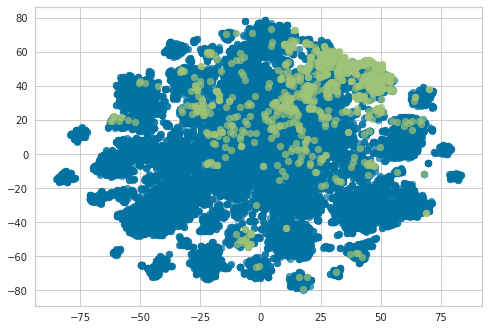

In [121]:
from yellowbrick.text import TSNEVisualizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Definimos el corpus y las etiquetas que nos ayudar��n en el split del train y test
tsne = TSNEVisualizer()
tsne.fit(dtm, corpus.iloc[:,1])


In [123]:
tsne.poof()

In [127]:
n=20
unique_labels = [0,1]
for label in unique_labels:
    freqs = np.array(corpus[corpus.Topic==label].sum(axis=0))[0]
    plt.figure(figsize=(15,10))
    inds = np.argsort(freqs)[::-1]
    #plt.plot(freqs[inds[:n]])    
    
    plt.barh(np.array(TF_vocabulary)[inds[:n]],freqs[inds[:n]] )
    #plt.xticks(range(n), np.array(TF_vocabulary)[inds[:n]], rotation=75)
    #plt.fill_between(
#
    plt.xlabel('Palabras ' + '"'+label+'"', fontsize=10)
    plt.title('Frecuencia de palabras para ' + '"'+label+'"', fontsize=16)
    plt.show()

NameError: name 'TF_vocabulary' is not defined

<Figure size 1080x720 with 0 Axes>